In [1]:
# from google.colab import drive
# import os
# drive.mount('/content/drive')
# os.chdir('/content/drive/My Drive/2022/classes/stat195/stat195project')
# print(os.getcwd())

In [2]:
# %%capture
# !pip install lassonet
# !pip install einops

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sys
import torch
import matplotlib.pyplot as plt

sys.path.append("aav/util")
sys.path.append("aav/stat195_pytorch_work")

from lassonet import LassoNetClassifier

from residue_encoding import ResidueIdentityEncoder
from mutation_encoding import MutationSequenceEncoder
from torch_cnn_lassonet import *
from train import *

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from tqdm.auto import tqdm
import pickle

# Data

## Examine Dataset

In [4]:
df = pd.read_csv("stat_195_project_data.csv")
df.head()

,sequence,partition,mutation_sequence,num_mutations,num_edits,viral_selection,is_viable
0,ADEEIRATNPIATEMYGSVSTNLQLGNR,designed,AD____A___I___M_________L___,6,6,-2.027259,False
1,ADEEIRATNPVATEQYGSVSTNQQRQNR,designed,AD____A_______________Q__Q__,5,5,-0.429554,True
2,ADEEIRTTNPVATEQWGGVSTNLQIGNY,designed,AD_____________W_G______I__Y,6,6,-0.527843,True
3,ADEEIRTTNPVATEQYGEVSTNLQRGNR,designed,AD_______________E__________,3,3,2.887908,True
4,ADEEIRTTNPVATEQYGSVSTNLQRGNR,designed,AD__________________________,2,2,0.575730,True


In [5]:
# print unique partitions
sorted(df["partition"].unique())

['cnn_designed_plus_rand_train_seed',
 'cnn_designed_plus_rand_train_walked',
 'cnn_rand_doubles_plus_single_seed',
 'cnn_rand_doubles_plus_single_walked',
 'cnn_standard_seed',
 'cnn_standard_walked',
 'designed',
 'lr_designed_plus_rand_train_seed',
 'lr_designed_plus_rand_train_walked',
 'lr_rand_doubles_plus_single_seed',
 'lr_rand_doubles_plus_single_walked',
 'lr_standard_seed',
 'lr_standard_walked',
 'previous_chip_nonviable',
 'previous_chip_viable',
 'rand',
 'random_doubles',
 'rnn_designed_plus_rand_train_seed',
 'rnn_designed_plus_rand_train_walked',
 'rnn_rand_doubles_plus_singles_seed',
 'rnn_rand_doubles_plus_singles_walked',
 'rnn_standard_seed',
 'rnn_standard_walked',
 'single',
 'singles',
 'stop',
 'wild_type']

In [6]:
len(df[df["partition"] == "designed"]) # additive model A_39 (complete)

56372

In [7]:
len(df[df["partition"] == "single"]) # complete singles C_1 (complete)

1112

In [8]:
len(df[df["partition"] == "random_doubles"]) # superset of R_2, which has n=1756 data points

25040

In [9]:
len(df[df["partition"] == "rand"]) # R_10 + validation dataset 
# R_10 has 7908 randomly generated mutants (2-10 mutations)
# validation dataset has 1977 mutants

9885

In [10]:
for num_mutations in range(2, 11):
    print("number of mutations:", num_mutations)
    print(len(df[(df["partition"] == "rand") & (df["num_mutations"] == num_mutations)]))

number of mutations: 2
1756
number of mutations: 3
1751
number of mutations: 4
1745
number of mutations: 5
1745
number of mutations: 6
1732
number of mutations: 7
288
number of mutations: 8
289
number of mutations: 9
290
number of mutations: 10
289


## Define datasets
- $C_1 + R_2$ dataset
- $C_1 + R_{10}$ dataset
- $R_{10} + A_{39}$ dataset
- holdout 1977 random multiples

In [11]:
# create validation dataset and r10 dataset
r10_plus_val = df[df["partition"] == "rand"]
val_df = r10_plus_val.sample(n=1977, replace=False, random_state=195)
r10 = r10_plus_val.drop(val_df.index)

for num_mutations in range(2, 11):
    print("number of mutations:", num_mutations)
    print(len(val_df[val_df["num_mutations"] == num_mutations]))

number of mutations: 2
323
number of mutations: 3
319
number of mutations: 4
359
number of mutations: 5
373
number of mutations: 6
366
number of mutations: 7
54
number of mutations: 8
59
number of mutations: 9
57
number of mutations: 10
67


In [12]:
# create r2 dataset
r2 = df[df["partition"] == "rand"].sample(n=1756, replace=False, random_state=195)

In [13]:
c1 = df[df["partition"] == "single"]

In [14]:
a39 = df[df["partition"] == "designed"]

In [15]:
# create train datasets
c1_r2 = pd.concat([c1, r2]).reset_index()
print(f"C1+R2 size: {len(c1_r2)}")

c1_r10 = pd.concat([c1, r10]).reset_index()
print(f"C1+R10 size: {len(c1_r10)}")

r10_a39 = pd.concat([r10, a39]).reset_index()
print(f"R10+A39 size: {len(r10_a39)}")

C1+R2 size: 2868
C1+R10 size: 9020
R10+A39 size: 64280


In [16]:
# 3 different training datasets (to ensure no overlap)
df_c1_r2 = df[df['partition'] != 'stop'].drop(c1.index).drop(r2.index).reset_index()
df_c1_r10 = df[df['partition'] != 'stop'].drop(c1.index).drop(r10.index).reset_index()
df_r10_a39 = df[df['partition'] != 'stop'].drop(r10.index).drop(a39.index).reset_index()

In [17]:
val_df.reset_index(inplace=True)
print(f"Validation size: {len(val_df)}")

Validation size: 1977


In [18]:
# The canonical single-letter code residue alphabet.
RESIDUES = tuple('ACDEFGHIKLMNPQRSTVWY')

# The AAV serotype 2 wild type subsequence corresponding to positions 561 to 588
R1_TILE21_WT_SEQ = 'DEEEIRTTNPVATEQYGSVSTNLQRGNR'

res_encoder = ResidueIdentityEncoder(alphabet=RESIDUES)
mut_encoder = MutationSequenceEncoder(res_encoder, R1_TILE21_WT_SEQ)

WT_ENCODED = mut_encoder.encode(R1_TILE21_WT_SEQ).reshape(-1, 20)
print(WT_ENCODED.shape)

(58, 20)


# Train LassoNet Model

In [19]:
NUM_MODELS = 3 # number of models per ensemble

In [20]:
# define validation data
X_val = []
for i in range(len(val_df)):
    X_val.append(mut_encoder.encode(val_df["sequence"][i]))
X_val = np.array(X_val)
X_val = X_val.reshape(len(X_val), -1)
y_val = val_df["is_viable"].to_numpy().astype(int)

In [21]:
def plot_metrics(models, paths):
    """
    models - ensemble of LassoNet models
    paths - list of path objects, each of which contains model parameters for a single LassoNet model
    """
    n = len(models)

    all_n_selected = [[] for _ in range(n)]
    all_accuracy = [[] for _ in range(n)]
    all_lambda_ = [[] for _ in range(n)]

    for i in range(n):
        n_selected = []
        accuracy = []
        lambda_ = []

        for save in paths[i]:
            models[i].load(save.state_dict)
            y_pred = models[i].predict(X_val)
            n_selected.append(save.selected.sum())
            accuracy.append(accuracy_score(y_val, y_pred))
            lambda_.append(save.lambda_)    

        all_n_selected[i] = n_selected
        all_accuracy[i] = accuracy
        all_lambda_[i] = lambda_

    fig = plt.figure(figsize=(12, 12))

    plt.subplot(311)
    plt.grid(True)
    for i in range(n):
        plt.scatter(all_n_selected[i], all_accuracy[i])
    plt.xlabel("number of selected features")
    plt.ylabel("classification accuracy")

    plt.subplot(312)
    plt.grid(True)
    for i in range(n):
        plt.plot(all_lambda_[i], all_accuracy[i], ".-")
    plt.xlabel("lambda")
    plt.xscale("log")
    plt.ylabel("classification accuracy")

    plt.subplot(313)
    plt.grid(True)
    for i in range(n):
        plt.plot(all_lambda_[i], all_n_selected[i], ".-")
    plt.xlabel("lambda")
    plt.xscale("log")
    plt.ylabel("number of selected features")

    plt.savefig("c1_r2_cnn_lassonet.png")
    
    plt.show()

    return all_n_selected, all_accuracy, all_lambda_


def train_cnn_lassonet(data, name, load_models=True):
    from aav.stat195_pytorch_work.torch_cnn_lassonet import CNNLassoNetClassifier
    X_train = []
    for i in range(len(data)):
        X_train.append(mut_encoder.encode(data["sequence"][i]))
    y_train = data["is_viable"].to_numpy().astype(int)
    X_train = np.array(X_train)

    X_train = X_train.reshape(len(X_train), -1)

    # define ensemble of models
    models = [None]*NUM_MODELS

    # attempt to load first, skip training if we already have the weights
    if load_models:
        with open(f"{name}_paths.pkl", "rb") as file:
            paths = pickle.load(file)
    else:
        paths = [None]*NUM_MODELS

    # train models
    for i in tqdm(range(NUM_MODELS)):
        models[i] = CNNLassoNetClassifier(
            M=1,
            batch_size=512,
            n_iters=(30, 10),
            lambda_start=1,
            path_multiplier=1.1
        )
        if not load_models:
            paths[i] = models[i].path(X_train, y_train, X_val=X_val, y_val=y_val)

    with open(f"{name}_paths.pkl", "wb") as file:
        pickle.dump(paths, file)

    return models, paths

  0%|          | 0/3 [00:00<?, ?it/s]


0it [00:00, ?it/s]
Iteration 0 - Lambda: 1, selected_count: 58: : 0it [00:00, ?it/s]
Iteration 0 - Lambda: 1, selected_count: 58: : 1it [00:00,  1.98it/s]
Iteration 1 - Lambda: 1.1, selected_count: 58: : 1it [00:00,  1.98it/s]
Iteration 1 - Lambda: 1.1, selected_count: 58: : 2it [00:00,  2.04it/s]
Iteration 2 - Lambda: 1.2100000000000002, selected_count: 58: : 2it [00:00,  2.04it/s]
Iteration 2 - Lambda: 1.2100000000000002, selected_count: 58: : 3it [00:01,  2.04it/s]
Iteration 3 - Lambda: 1.3310000000000004, selected_count: 58: : 3it [00:01,  2.04it/s]
Iteration 3 - Lambda: 1.3310000000000004, selected_count: 58: : 4it [00:01,  2.06it/s]
Iteration 4 - Lambda: 1.4641000000000006, selected_count: 58: : 4it [00:01,  2.06it/s]
Iteration 4 - Lambda: 1.4641000000000006, selected_count: 58: : 5it [00:02,  2.04it/s]
Iteration 5 - Lambda: 1.6105100000000008, selected_count: 58: : 5it [00:02,  2.04it/s]
Iteration 5 - Lambda: 1.6105100000000008, selected_count: 58: : 6it [00:02,  2.06it/s]
Iter

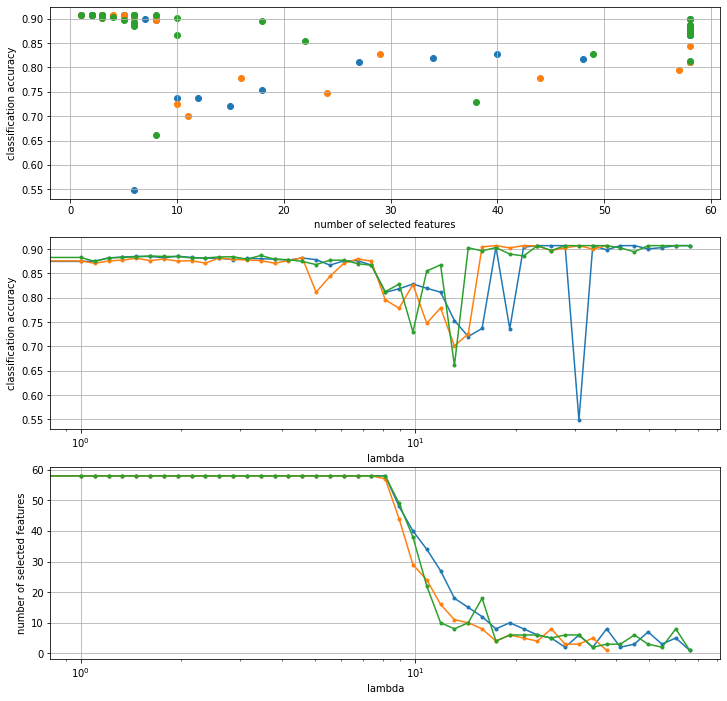

In [22]:
models_cnn_lassonet, paths_cnn_lassonet = train_cnn_lassonet(c1_r2, "c1_r2", load_models=False)
all_n_selected, all_accuracy, all_lambda_ = plot_metrics(models_cnn_lassonet, paths_cnn_lassonet)

## Examine Sparsity

Model number: 26


C:\Users\William\anaconda3\envs\stat195project\lib\site-packages\ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


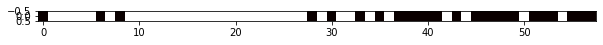

Model number: 25


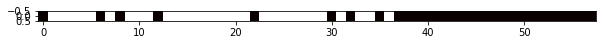

Model number: 26


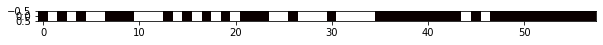

In [23]:
# view sparse locations on example model

N_FEATURES = 35 # determine by inspection

all_n_selected = np.array(all_n_selected) # default sorted from greatest to least
indices = [] # indices of particular model to choose from path of models, one index for each model in ensemble

# examine 3 example
for i in range(NUM_MODELS):
    n_selected = all_n_selected[i]
    idx = list(n_features < N_FEATURES for n_features in n_selected).index(True) # find first index with number of features < N_FEATURES
    paths_cnn_lassonet[i][idx].selected.numpy()
    indices.append(idx)

    print("Model number:", idx)
    plt.figure(figsize=(10, 5))
    plt.imshow(paths_cnn_lassonet[i][idx].selected.numpy().reshape(1, 58), cmap='hot', interpolation='nearest')
    
    plt.savefig("c1_r2_cnn_sparsity.png")
    plt.show()

    # white pixels are 1 and black pixels are 0
    # left: substitution, right: insertion
    # looks like insertions have so much effect

# Model-selected Seeds

In [24]:
NUM_SAMPLES_PER_MUTATION = int(1000)
N_LARGEST_VIABILITIES_SEED = 50
mut_dists = np.arange(5, 26)
load_samples = False

WT_ENCODED = mut_encoder.encode(R1_TILE21_WT_SEQ).reshape(-1, 20)

# let's store everything as a (58, 20) object

## Create Samples

In [25]:
# create initial samples at every level of mutation

if load_samples:
    with open("samples.pkl", "rb") as file:
        samples = pickle.load(file)
else:
    samples = {mut_dist: [] for mut_dist in mut_dists}

    for mut_dist in tqdm(mut_dists):
        for i in range(NUM_SAMPLES_PER_MUTATION):
            sample_indices = np.random.choice(np.arange(1, 58), size=mut_dist, replace=False) # don't sample prefix substitution
            sample = np.copy(WT_ENCODED)
            for mut in sample_indices:
                if mut % 2 == 0: # if it is a substitution / part of the original sequence
                    idx = np.argmax(res_encoder.encode(R1_TILE21_WT_SEQ[(mut-1)//2]))
                    residues_excluding_wt = np.setdiff1d(np.arange(20),np.array(idx)) # exclude wildtype from possible choices
                    residue_idx = np.random.choice(residues_excluding_wt)
                else:
                    residue_idx = np.random.choice(np.arange(20))
                sample[mut] = np.zeros(20)
                sample[mut][residue_idx] = 1
            samples[mut_dist].append(sample)

if not load_samples:
    with open("samples.pkl", "wb") as file:
        pickle.dump(samples, file)

  0%|          | 0/21 [00:00<?, ?it/s]

In [26]:
def calculate_mut_dist(sample):
    ans = 0
    for mut1, mut2 in zip(sample.reshape(-1, 20), WT_ENCODED.reshape(-1, 20)):
        if np.any(mut1 != mut2):
            ans += 1
    return ans

In [27]:
# model selected seeds

def generate_best_muts(models, paths=None, samples=samples, topk=N_LARGEST_VIABILITIES_SEED):
    """
    Given ensemble of models and samples, generate the top k viable samples for each mutation distance
    If paths=None, can be used for logistic regression, etc.
    """
    seeds = {mut_dist: [] for mut_dist in mut_dists}

    for mut_dist in mut_dists:
        # print(f"Mutation distance: {mut_dist}")
        ensemble_y_pred_proba = np.zeros((NUM_MODELS, len(samples[mut_dist]), 2))
        for i in range(NUM_MODELS):
            if paths != None:
                save = paths[i][indices[i]] # choose model from path of models
                models[i].load(save.state_dict)
            ensemble_y_pred_proba[i] = models[i].predict_proba(np.array(samples[mut_dist]).reshape(-1, 1160))
        viable_proba = np.mean(ensemble_y_pred_proba, axis=0)[:,1] # probabilities of viabile
        top_viable_indices = np.argpartition(viable_proba, -topk)[-topk:]

        seeds[mut_dist] = np.array(samples[mut_dist])[top_viable_indices]

    return seeds

## Train Logistic Regression as Benchmark

In [28]:
def train_logistic_regression(data, name):
    X_train = []
    for i in range(len(data)):
        X_train.append(mut_encoder.encode(data["sequence"][i]))
    y_train = data["is_viable"].to_numpy().astype(int)
    X_train = np.array(X_train)

    X_train = X_train.reshape(len(X_train), -1)

    # define ensemble of models
    models = [None]*NUM_MODELS
    paths = [None]*NUM_MODELS

    # train models
    for i in tqdm(range(NUM_MODELS)):
        models[i] = LogisticRegression(random_state=i)
        models[i].fit(X_train, y_train)

    return models, paths

In [29]:
models_logistic, paths_logistic = train_logistic_regression(c1_r2, "c1_r2")

  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\William\anaconda3\envs\stat195project\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
C:\Users\William\anaconda3\envs\stat195project\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/s

## Train Synthetic Model as Ground-Truth

In [30]:
# train cnn model as ground truth

def train_synthetic_model(data, name, load_model=True):

    # prepare dataset
    sequences = []
    for i, row in data.iterrows():
        seq = row['sequence']
        np_seq = mut_encoder.encode(seq).astype(np.float32)
        sequences.append(np_seq.reshape(1, -1, np_seq.shape[-1]))
    sequences = np.concatenate(sequences, axis=0)

    # split dataset
    train_set, test_set = train_test_split(data, test_size=0.2)

    # train model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if load_model:
        with open(f"synthetic_{name}", "rb") as file:
            model = torch.load(file)
    else:
        model = CNNModel()
        model.path(sequences[train_set.index.values], train_set['is_viable'].values)
        
        with open(f"synthetic_{name}", "wb") as file:
            torch.save(model, file)

    y_pred = model.predict(sequences[test_set.index.values])
    print(f"Accuracy of Synthetic Model on Test Set is {sum(y_pred == test_set['is_viable']) / len(y_pred)}")

    return model

def test_synthetic_model(seeds, model, label="LassoNet"):
    accuracies = []
    for mut_dist in mut_dists:
        seeds_mut_dist = np.array(seeds[mut_dist]).reshape(-1, 58, 20)
        synthetic_model_pred = model.predict(seeds_mut_dist.astype(np.float32))
        accuracy = np.sum(synthetic_model_pred) / len(seeds[mut_dist])
        # print(f"Mutation distance: {mut_dist}, Accuracy according to Synthetic Model: {accuracy}")
        accuracies.append(accuracy)
    
    # plot accuracies
    plt.plot(mut_dists, accuracies, label=label)
    plt.scatter(mut_dists, accuracies)


In [31]:
model_synthetic = train_synthetic_model(df_c1_r2, "c1_r2", load_model=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Accuracy of Synthetic Model on Test Set is 0.95221819789488


## Test on Model-selected Seeds

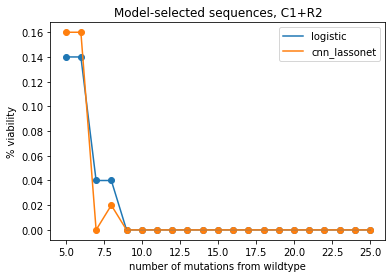

In [32]:
seeds_logistic = generate_best_muts(models_logistic, paths=None)
test_synthetic_model(seeds_logistic, model_synthetic, label="logistic")

seeds = generate_best_muts(models_cnn_lassonet, paths_cnn_lassonet)
test_synthetic_model(seeds, model_synthetic, label="cnn_lassonet")

plt.legend()
plt.xlabel("number of mutations from wildtype")
plt.ylabel("% viability")
plt.title("Model-selected sequences, C1+R2")
plt.savefig("selected_cnn_c1_r2.png")
plt.show()

# Model-designed Sequences

In [33]:
# change the black (irrelevant) features, and mutate in the design sequences process
# we need two design processes, one for features and one imitating the regular one

In [34]:
def mutate_samples_normal(samples):
    new_samples_iterative = {mut_dist: [] for mut_dist in mut_dists}

    for mut_dist in mut_dists:
        samples_mut_dist = np.array(samples[mut_dist]).squeeze()
        for sample in samples_mut_dist:
            sample = np.copy(sample).reshape(58, 20)
            mut = np.random.choice(np.arange(1, 58))
            if mut % 2 == 0: # if it is a substitution / part of the original sequence
                idx = np.argmax(res_encoder.encode(R1_TILE21_WT_SEQ[(mut-1)//2]))
                residues_excluding_wt = np.setdiff1d(np.arange(20),np.array(idx)) # exclude wildtype from possible choices
                residue_idx = np.random.choice(residues_excluding_wt)
            else:
                residue_idx = np.random.choice(np.arange(20))
            sample[mut] = np.zeros(20)
            sample[mut][residue_idx] = 1

            sample_mut_dist = calculate_mut_dist(sample)
            if 5 <= sample_mut_dist and sample_mut_dist < 26:
                new_samples_iterative[sample_mut_dist].append(sample)
    
    return new_samples_iterative

def mutate_samples_lassonet(samples):
    new_samples_iterative = {mut_dist: [] for mut_dist in mut_dists}

    for mut_dist in mut_dists:
        samples_mut_dist = np.array(samples[mut_dist]).squeeze()
        for sample in samples_mut_dist:
            sample = np.copy(sample).reshape(58, 20)
            mut = np.random.choice(np.arange(30, 58))
            if mut % 2 == 0: # if it is a substitution / part of the original sequence
                idx = np.argmax(res_encoder.encode(R1_TILE21_WT_SEQ[(mut-1)//2]))
                residues_excluding_wt = np.setdiff1d(np.arange(20),np.array(idx)) # exclude wildtype from possible choices
                residue_idx = np.random.choice(residues_excluding_wt)
            else:
                residue_idx = np.random.choice(np.arange(20))
            sample[mut] = np.zeros(20)
            sample[mut][residue_idx] = 1

            sample_mut_dist = calculate_mut_dist(sample)
            if 5 <= sample_mut_dist and sample_mut_dist < 26:
                new_samples_iterative[sample_mut_dist].append(sample)
    
    return new_samples_iterative

In [35]:
# random set of 250 single mutations
# take the 50 highest scoring candidates, pass forward to next iteration
# terminate the process after 20 iterations
# aggregate with model-selected seeds, select the top 900 at each distance 5-25, top 500 at distances 26-29

import copy
NUM_ITERS = 15

def iteratively_mutate_normal(models, samples, paths=None, mutate_fn=None):
    samples_iterative = copy.deepcopy(samples)
    all_candidates = {mut_dist: [] for mut_dist in mut_dists}

    for iter in tqdm(range(NUM_ITERS)):
        # find best mutants according to model
        new_samples_iterative = copy.deepcopy(generate_best_muts(models, paths=paths, samples=samples_iterative, topk=50))
        
        # append to growing list of total findings mutations
        for mut_dist in mut_dists:
            all_candidates[mut_dist].append(new_samples_iterative[mut_dist])

        # mutate samples
        new_samples_iterative = mutate_fn(samples)
        
        samples_iterative = copy.deepcopy(new_samples_iterative)

    # print(all_candidates)

    for mut_dist in mut_dists:
        # print(f"MUT DIST: {mut_dist}")
        # for candidate in all_candidates[mut_dist]:
            # print(candidate.shape)
        all_candidates[mut_dist] = np.concatenate(all_candidates[mut_dist], axis=0)
    
    best_candidates = generate_best_muts(models, samples=all_candidates, paths=paths, topk=50)
    
    return best_candidates

## Test on Model-designed Seeds

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

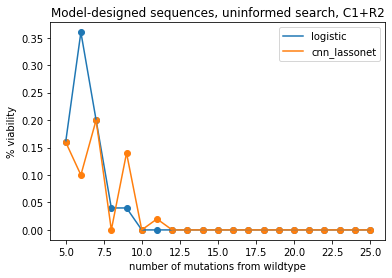

In [36]:
designed_logistic = iteratively_mutate_normal(models_logistic, samples=samples, paths=None, mutate_fn=mutate_samples_normal)
test_synthetic_model(designed_logistic, model_synthetic, label="logistic")

designed_lassonet = iteratively_mutate_normal(models_cnn_lassonet, samples=samples, paths=None, mutate_fn=mutate_samples_normal)
test_synthetic_model(designed_lassonet, model_synthetic, label="cnn_lassonet")

plt.legend()
plt.xlabel("number of mutations from wildtype")
plt.ylabel("% viability")
plt.title("Model-designed sequences, uninformed search, C1+R2")
plt.savefig("designed_uninformed_cnn_c1_r2.png")
plt.show()

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

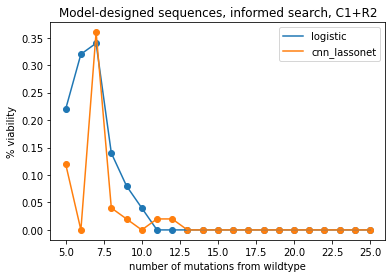

In [37]:
designed_logistic = iteratively_mutate_normal(models_logistic, samples=samples, paths=None, mutate_fn=mutate_samples_lassonet)
test_synthetic_model(designed_logistic, model_synthetic, label="logistic")

designed_lassonet = iteratively_mutate_normal(models_cnn_lassonet, samples=samples, paths=None, mutate_fn=mutate_samples_lassonet)
test_synthetic_model(designed_lassonet, model_synthetic, label="cnn_lassonet")

plt.legend()
plt.xlabel("number of mutations from wildtype")
plt.ylabel("% viability")
plt.title("Model-designed sequences, informed search, C1+R2")
plt.savefig("designed_informed_cnn_c1_r2.png")
plt.show()